In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from models.model_fpgan import FPGANSynthesizer
from models.model_ctgan import CTGANSynthesizer
from models.model_dpctgan import DPCTGANSynthesizer

import ctgan
from sklearn.model_selection import train_test_split
from utils.privacy import normalized_avg_dist
from utils.fidelity import get_predictions, eval_fidelity, get_accuracy, get_roc_auc, get_class_ratios

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
data = pd.read_csv("D:/Datasets/cardiovascular/cardio.csv",sep=";")
data = data.drop(columns=['id'])
data.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
data.shape

(70000, 12)

In [5]:
#normalized_data=(data-data.mean())/data.std()
data=(data-data.min())/(data.max()-data.min())

In [6]:
target = 'cardio'

In [7]:
X = data.drop(columns=[target])
y = data[target]

In [8]:
y_series = pd.Series(y)

# Calculate the class distribution
class_distribution = y_series.value_counts(normalize=True) * 100

print(class_distribution)

0.0    50.03
1.0    49.97
Name: cardio, dtype: float64


In [8]:
#model_ctgan = CTGANSynthesizer(epochs=20)
#model_ctgan = DPCTGANSynthesizer(verbose=True, epochs=20)
model_ctgan = FPGANSynthesizer(verbose=True, epochs=20)
#original_losses, tranformed_privacies, losses = model_ctgan.fit(data)
model_ctgan.fit(data, rate=0.75)

Epoch 1, Loss G: -0.2161,Loss D: -0.0451
Epoch 2, Loss G: -0.1167,Loss D:  0.0520
Epoch 3, Loss G:  0.0158,Loss D: -0.4723
Epoch 4, Loss G:  0.1202,Loss D: -0.4640
Epoch 5, Loss G:  0.0548,Loss D: -0.4810
Epoch 6, Loss G: -0.0463,Loss D:  0.1246
Epoch 7, Loss G: -0.0203,Loss D: -0.1872
Epoch 8, Loss G:  0.0187,Loss D: -0.1681
Epoch 9, Loss G:  0.0458,Loss D: -0.1267
Epoch 10, Loss G: -0.0439,Loss D: -0.2876
Epoch 11, Loss G: -0.1290,Loss D:  0.1146
Epoch 12, Loss G:  0.0159,Loss D: -0.1280
Epoch 13, Loss G: -0.0005,Loss D:  0.1210
Epoch 14, Loss G:  0.0176,Loss D:  0.0361
Epoch 15, Loss G: -0.0163,Loss D:  0.1255
Epoch 16, Loss G:  0.0556,Loss D: -0.2799
Epoch 17, Loss G: -0.1070,Loss D:  0.2514
Epoch 18, Loss G: -0.0139,Loss D: -0.3298
Epoch 19, Loss G:  0.0366,Loss D: -0.2553
Epoch 20, Loss G: -0.0704,Loss D: -0.2206


([array(0.01538372, dtype=float32),
  array(0.0144621, dtype=float32),
  array(0.01330911, dtype=float32),
  array(0.02372961, dtype=float32),
  array(0.01431589, dtype=float32),
  array(0.0259159, dtype=float32),
  array(0.02550031, dtype=float32),
  array(0.02919791, dtype=float32),
  array(0.03601481, dtype=float32),
  array(0.01113612, dtype=float32),
  array(0.01788511, dtype=float32),
  array(0.01123051, dtype=float32),
  array(-0.00046303, dtype=float32),
  array(-0.01433457, dtype=float32),
  array(-0.0457322, dtype=float32),
  array(-0.04911463, dtype=float32),
  array(-0.07521483, dtype=float32),
  array(-0.10692137, dtype=float32),
  array(-0.14151512, dtype=float32),
  array(-0.17674486, dtype=float32),
  array(-0.2082209, dtype=float32),
  array(-0.21297832, dtype=float32),
  array(-0.23977001, dtype=float32),
  array(-0.2616185, dtype=float32),
  array(-0.26394442, dtype=float32),
  array(-0.26706842, dtype=float32),
  array(-0.2581817, dtype=float32),
  array(-0.27240112

In [9]:
from utils.utils import save_models
save_models(model_ctgan, '075fpgan20', 'cardio')

In [10]:
from utils.utils import load_models
model_ctgan = load_models('075fpgan20', 'cardio')

In [11]:
samples = model_ctgan.sample(len(data))  # Synthetic copy
samples.dropna(how='any', inplace=True)

X_syn = samples.drop(columns=[target])
y_syn = samples[target]
y_syn = y_syn.round(0)
y_syn = y_syn.astype(int)

## Privacy

In [12]:
samples = samples.apply(pd.to_numeric) # convert all columns of DataFrame
data = data.apply(pd.to_numeric) # convert all columns of DataFrame
samples = samples[:2000]
data = data[:2000]

In [13]:
normalized_avg_distance = normalized_avg_dist(samples, data)
print(normalized_avg_distance)

[0.02499846]


## Fidelity

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_syn_train, X_syn_test, y_syn_train, y_syn_test = train_test_split(X_syn, y_syn, test_size=0.3, random_state=42, stratify=y_syn)

rr_pred = []
fr_pred = []
ff_pred = []
rf_pred = []

rr_pred = get_predictions(X_train, y_train, X_test, y_test, undersample = False)
fr_pred = get_predictions(X_syn_train, y_syn_train, X_test, y_test, undersample = False)

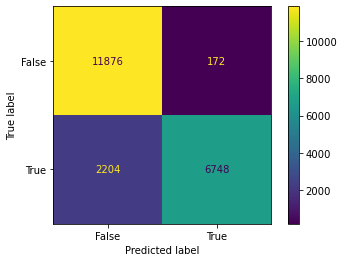

In [15]:
from sklearn import metrics
def print_confusion_matrix(rr_pred, fr_pred):
    confusion_matrix = metrics.confusion_matrix(rr_pred, fr_pred)

    cm_display1 = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

    cm_display1.plot()
    plt.show()
    
print_confusion_matrix(rr_pred, fr_pred)

In [16]:
percentage = eval_fidelity(rr_pred, fr_pred)

In [17]:
rr_acc = get_accuracy(y_test, rr_pred)
fr_acc = get_accuracy(y_test, fr_pred)
print("Accuracy of real data: ", rr_acc)
print("Accuracy of synthetic data: ", fr_acc)

Accuracy of real data:  0.7257142857142858
Accuracy of synthetic data:  0.698952380952381


In [18]:
rr_score = get_roc_auc(y_test, rr_pred)
fr_score = get_roc_auc(y_test, fr_pred)
print("ROC AUC of real data: ", rr_score)
print("ROC AUC of synthetic data: ", fr_score)

ROC AUC of real data:  0.7256722369541997
ROC AUC of synthetic data:  0.6988550309186494


In [19]:
ratio_class1, ratio_class2 = get_class_ratios(rr_pred, fr_pred, target)

0 18624 2376 0


## Final plot

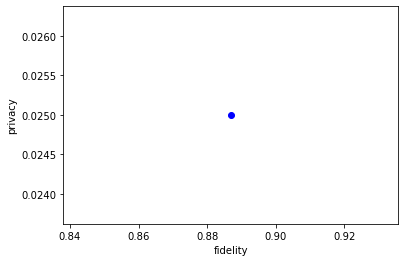

0.8868571428571429 [0.02499846]


In [20]:
plt.scatter(percentage, normalized_avg_distance, c ="blue")
plt.xlabel("fidelity")
plt.ylabel("privacy")
plt.show()
print(percentage, normalized_avg_distance)